In [1]:
#Initialization
import numpy as np
import pandas as pd
import os
from scipy import signal
from scipy.stats import gennorm
import matplotlib.pyplot as plt
import pickle

# 参数设定★

In [2]:
#总参数
total_time = 110
fs = 2560
time_duration = .1

In [3]:
#副参数
frequency_range = fs/2
resolution = 1/time_duration
total_points = total_time * fs
spectrum_length = int(frequency_range/resolution)+1

base = np.arange(0, total_time, 1 / fs)

# 从文件夹提取转速★

从NN文件夹中获取保存的神经网络模型

In [4]:
class NNs():
    def __init__(self, nn_func):
        self.variables = []
        for var in nn_func.variables:
            self.variables.append(var.numpy())

    def nn(self, x):
        for i in range(5):
            x = np.matmul(x, self.variables[i * 2]) 
            x = x + self.variables[i * 2 + 1]
            x = np.maximum(x, 0)
        x = np.matmul(x, self.variables[-2]) + self.variables[-1]
        return x

    def __call__(self, x):
        curve = (self.nn(np.reshape(x / 14000, [-1, 1])) - self.nn(np.array([[0]]))[:, 0]) * 11000
        return curve[:, 0]
    
def loadNN(NNDir):
    objfile = open('NN\\' + NNDir, 'rb')
    NN = pickle.load(objfile)
    objfile.close()
    return NN

s_u = loadNN('s_u')
s_d = loadNN('s_d')
s_s = loadNN('s_s')

# 波形处理器

In [5]:
class Wave_Processor():
    def __init__(self):
        pass

    def filt(self, wave, fs, lowfre, highfre):
        index = signal.firwin(501, highfre / (fs / 2), pass_zero=True)
        wave1 = np.convolve(wave, index)[250:-250]
        index2 = signal.firwin(501, lowfre / (fs / 2), pass_zero=False)
        filtwave = np.convolve(wave1, index2)[250:-250]
        return filtwave.astype('float32')

    def env(self, wave):
        hilbertwave = signal.hilbert(wave)
        envwave = abs(hilbertwave)
        envwave = envwave - np.mean(envwave)
        return envwave.astype('float32')

    def fft(self, wave, fs):
        frequency = np.linspace(0, fs/2, int(len(wave)/2)+1)
        window = signal.hann(len(wave))
        spec_full = np.fft.fft(wave * window) * 2 * 2 / len(wave)
        spec = spec_full[:len(frequency)]
        return frequency, spec

    def stft(self, wave, fs, time_duration, return_complex = False):
        frequency, time, spec = signal.stft(wave,
                                            fs,
                                            window=np.zeros(shape = int(time_duration * fs))+1/int(time_duration * fs),
                                            nperseg=int(time_duration * fs),
                                            noverlap=int(time_duration * fs) - 1)
        if return_complex == False:
            spec = abs(spec * 2)
            return frequency, time, spec
        else:
            return frequency, time, spec

    def __call__(self, index):
        pass
    

WP = Wave_Processor()

# 设计信号细节

## Two_Hot函数

将1d转速数组通过广义高斯分布转化为二维时频谱

In [6]:
def two_hot(NN, fs, resolution, beta = 21., gamma = 1.1, theta = 1.8):
    '''
    NN is an 1d array: the speed
    '''
    pix = np.reshape(np.arange(0, fs / 2 + resolution, resolution), [1, -1])
    fn = np.reshape(NN / 60, [-1, 1])
    fn2 = np.tile(fn, [1, int(fs / 2 / resolution + 1)])

    tf_map = (theta * gennorm.pdf((fn2 - pix) * 1 / (resolution*gamma), beta)).astype('float32')
    ft_map = tf_map.T

    return ft_map

试出最好的two hot参数

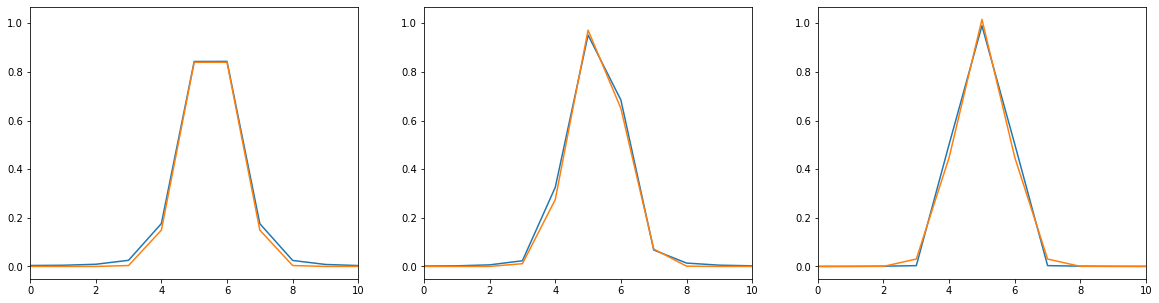

In [7]:
beta = 2.1
gamma = 1.1
theta = 1.8

for i in range(1):
    
    a,b1 = WP.fft(np.sin(2*np.pi*5.5*np.arange(0,1,1/100)),100)
    a,b2 = WP.fft(np.sin(2*np.pi*5.25*np.arange(0,1,1/100)),100)
    a,b3 = WP.fft(np.sin(2*np.pi*5.*np.arange(0,1,1/100)),100)

    plt.figure(figsize = [20,5])

    ax1 = plt.subplot(131)
    plt.plot(abs(b1))
    plt.plot(two_hot(np.zeros(shape = [100,])+(5.5)*60,100,1, beta,gamma,theta)[:,10])
    plt.xlim(0,10)

    plt.subplot(132, sharey = ax1, sharex = ax1)
    plt.plot(abs(b2))
    plt.plot(two_hot(np.zeros(shape = [100,])+(5.25)*60,100,1, beta,gamma,theta)[:,10])

    plt.subplot(133, sharey = ax1, sharex = ax1)
    plt.plot(abs(b3))
    plt.plot(two_hot(np.zeros(shape = [100,])+(5)*60,100,1, beta,gamma,theta)[:,10])
    plt.show()

## Sin 函数(+随机初相位)

In [8]:
def sin_wave(f, A, base, fat):
    wave = A * np.sin(f * (2 * np.pi) * (base + fat))
    return wave

def cos_wave(f, A, base, fat):
    wave = A * np.cos(f * (2 * np.pi) * (base + fat))
    return wave

## 幅值-转速曲线

In [9]:
def AH_curve(n):
    A = (2 * gennorm.pdf((n - 13000) * 1 / (13000/2), 2) +
         0.6 * gennorm.pdf((n - 2220) * 1 / (500), 2) +
         0.5 * gennorm.pdf((n - 3600) * 1 / (500), 2) +
         1.2 * gennorm.pdf((n - 6000) * 1 / (800), 2)).astype('float32')
    return A

def AL_curve(n):
    A = (2 * gennorm.pdf((n - 9000) * 1 / (9000/2), 2) +
         0.4 * gennorm.pdf((n - 2220) * 1 / (400), 2) +
         0.1 * gennorm.pdf((n - 4000) * 1 / (400), 2) +
         0.4 * gennorm.pdf((n - 6000) * 1 / (800), 2)).astype('float32')
    return A

## n倍频幅值定义

In [10]:
def Axs(A_curve, n1, init_amp):
    a = []
    for i in range(len(n1)):
        a.append(init_amp * ((2 / 3)**i) * A_curve(n1[0]))# * (1 + np.random.normal(size = n1[0].shape)/40))
    return a

## 叠加生成完整的时频谱

In [11]:
def full_ft_map(NHxs, NLxs, AHxs, ALxs, fs, resolution):
    ft_map = 0
    for i in range(len(NHxs)):
        ft_map += AHxs[i] * two_hot(NHxs[i], fs, resolution)
        ft_map += ALxs[i] * two_hot(NLxs[i], fs, resolution)
    return ft_map

In [12]:
def full_ft_map_complex(NHxs, NLxs, AHxs, ALxs, fs, resolution, base):
    ft_map = 0
    for i in range(len(NHxs)):
        ft_map += AHxs[i] * two_hot(NHxs[i], fs, resolution)
        ft_map += ALxs[i] * two_hot(NLxs[i], fs, resolution)
    #ft_map[np.arange(0, int(fs/resolution/2),2)] = - ft_map[np.arange(0, int(fs/resolution/2),2)]
    ft_map_complex = ft_map.astype('complex64')
    
    for i in range(len(ft_map_complex)):
        fat = np.random.random()
        ft_map_complex[i] = ft_map_complex[i].real*cos_wave(i*resolution, 1, base, fat) + ft_map_complex[i].real*sin_wave(i*resolution, 1, base, fat)*1j    
    return ft_map_complex

## 定义具体升速曲线★

In [13]:
NHx1 = np.load('NH_SuperDense.npy')#np.zeros(shape = [total_points,]) + 13000#
NLx1 = s_u(NHx1)

## 定义其他参数★

In [14]:
NHx2 = 2 * NHx1
NLx2 = 2 * NLx1
NHx3 = 3 * NHx1
NLx3 = 3 * NLx1

NHxs = [NHx1, NHx2, NHx3]
NLxs = [NLx1, NLx2, NLx3]

AHxs = Axs(AH_curve, NHxs, 15.)
ALxs = Axs(AL_curve, NLxs, 10.)

ft_map = full_ft_map(NHxs, NLxs, AHxs, ALxs, fs, resolution)
ft_map_complex = full_ft_map_complex(NHxs, NLxs, AHxs, ALxs, fs, resolution, base)

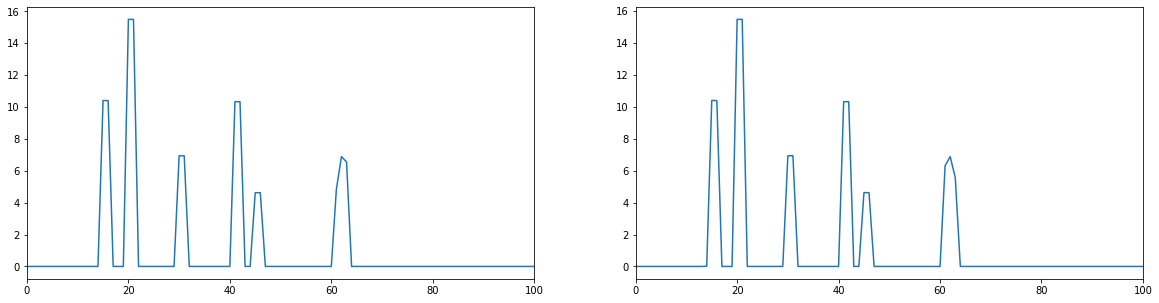

In [15]:
#
plt.figure(figsize = [20,5])
plt.subplot(121)
plt.plot(ft_map[:,-5120])
plt.xlim(0,100)
plt.subplot(122)
plt.plot(abs(ft_map_complex)[:,-15120])
plt.xlim(0,100)
plt.show()

## 展示信号细节图像

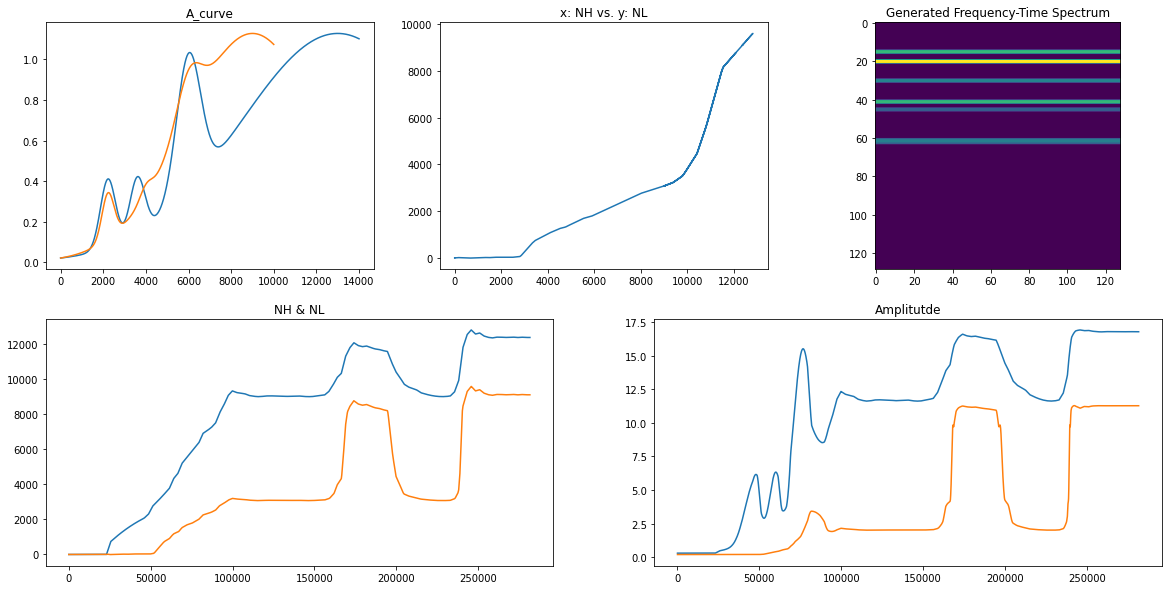

In [16]:
#Visualization
plt.figure(figsize = [20,10])
plt.subplot(231)
plt.title('A_curve')
plt.plot(AH_curve(np.arange(0,14000,1)))
plt.plot(AL_curve(np.arange(0,10000,1)))
plt.subplot(232)
plt.title('x: NH vs. y: NL')
plt.plot(NHx1,NLx1)
plt.subplot(233)
plt.title('Generated Frequency-Time Spectrum')
plt.imshow(ft_map[:, -spectrum_length: -1])
plt.subplot(223)
plt.title('NH & NL')
plt.plot(NHx1)
plt.plot(NLx1)
plt.subplot(224)
plt.title('Amplitutde')
plt.plot(AHxs[0])
plt.plot(ALxs[0])
plt.show()

# Sin叠加法构建波形（无噪声）

## 叠加全频率的Sin函数构建波形

In [17]:
def wave_recon(ft_map, frequency_range, resolution, base):
    wave = 0
    f = np.arange(0, frequency_range, resolution)
    for i in range(len(f)):
        wave += sin_wave(f[i], ft_map[i], base, 0)
    return wave

## 构建波形&添加噪声★

In [18]:
noise = (np.arange(0, 1, 1 / total_points)) * 10 * np.random.normal(size=[total_points,])
wave_r = wave_recon(ft_map, frequency_range, resolution, base) #+ noise

## 展示构建的波形

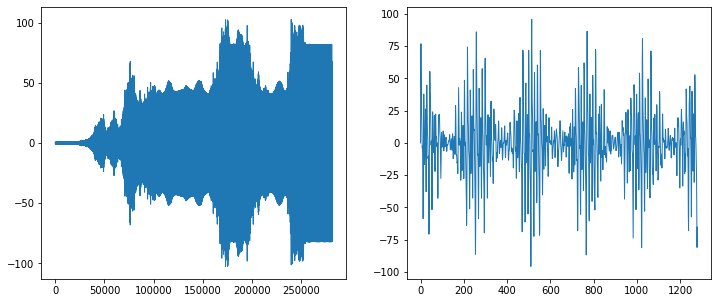

In [19]:
#Visualization
plt.figure(figsize=[12,5])
plt.subplot(121)
plt.plot(wave_r[:], linewidth = 1)
plt.subplot(122)
plt.plot(wave_r[int(0.6*total_points): int(0.6*total_points + fs/2)], linewidth = 1)

# 逆短时傅里叶变换法重构波形（有噪声）

## 构建波形&添加噪声★

In [23]:
noise = (np.arange(0, 1, 1 / total_points)) * 20 * np.random.normal(size=[total_points,])
_, wave_r = signal.istft(ft_map_complex, fs, window='hann', nperseg=int(time_duration * fs)-1,noverlap=int(time_duration * fs) - 2)
wave_r = wave_r + noise

## 展示构建的波形

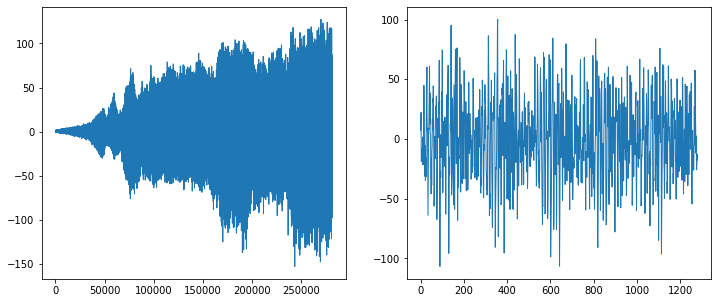

In [24]:
#Visualization
plt.figure(figsize=[12,5])
plt.subplot(121)
plt.plot(wave_r[:], linewidth = 1)
plt.subplot(122)
plt.plot(wave_r[int(0.6*total_points): int(0.6*total_points + fs/2)], linewidth = 1)

# 对重构波形做STFT★

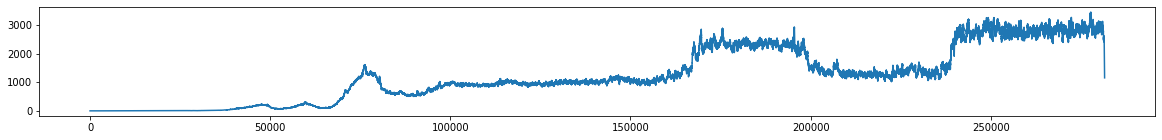

In [29]:
f, t, spec = WP.stft(wave_r, fs, time_duration)

plt.figure(figsize = [20,2])
plt.plot(np.sum(spec**2, axis = 0))
plt.show()

## 选取随机点进行结果可视化

同时保存完整图片在Visualization文件夹

234644


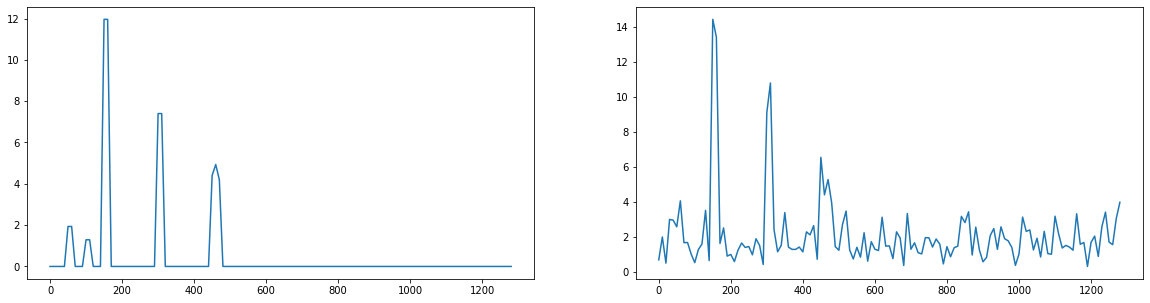

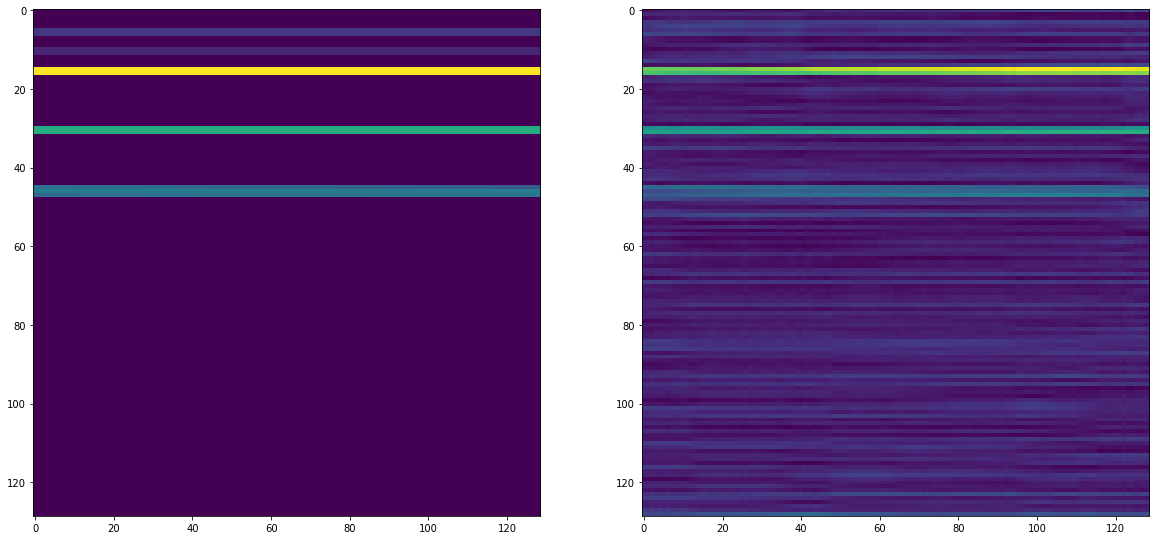

In [30]:
#Visualization
randomone = int(np.random.random()*(total_points-spectrum_length))

print(randomone)

plt.figure(figsize = [20, 5])
plt.subplot(121)
plt.plot(f, ft_map[:,randomone])
plt.subplot(122)
plt.plot(f, spec[:,randomone])

plt.figure(figsize = [20, 10])
plt.subplot(121)
plt.imshow(ft_map[:, randomone:randomone+spectrum_length])
plt.subplot(122)
plt.imshow(spec[:, randomone:randomone+spectrum_length])
plt.show()


plt.imsave('Visualization\\Simulated_Spectrum.png', ft_map[:int(750/resolution), np.arange(0, 110 * fs, int(0.5*fs))][::-1])
plt.imsave('Visualization\\ReGenerated_Spectrum.png', spec[:int(750/resolution), np.arange(0, 110 * fs, int(0.5*fs))][::-1])

## 3D可视化

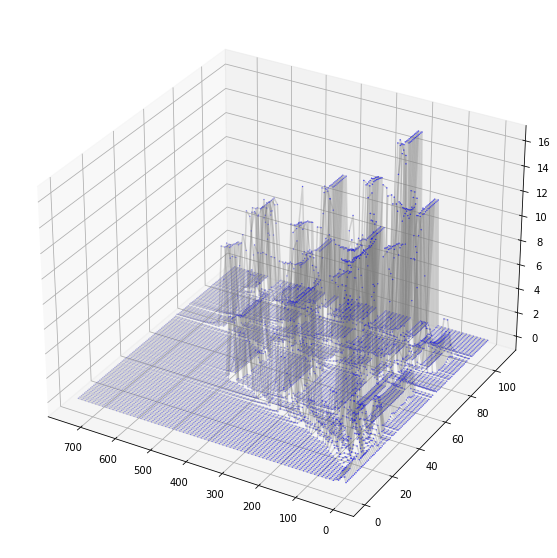

In [22]:
start = 0
end = 110
line_amount = 110

#%matplotlib
plt.figure(figsize=[10, 10])

ax3d = plt.subplot(111, projection='3d')
for i in range(line_amount):
    X = f[:int(750/resolution)]
    Y = np.tile(t[int((fs*start/line_amount) + i * (fs*(end-start)/line_amount))], [int(750/resolution)])
    Z = spec[:int(750/resolution), int((fs*start/line_amount) + i * (fs*(end-start)/line_amount))]
    ax3d.plot(X, Y, Z, c='gray', alpha=0.3)
    ax3d.scatter(X, Y, Z, s = .1, c = 'b')
ax3d.invert_xaxis()
#plt.axis('off')
plt.show()

# 保存数据为DataFrame格式数据集

In [ ]:
data = np.concatenate((np.reshape(NHx1, [-1, 1]), np.reshape(NLx1, [-1, 1]), spec.T), axis = 1)
pd.DataFrame(data).to_csv('WAVE_data.csv', index = False)